# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.10.2 which is incompatible.


In [2]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import optuna
import json
import glob
import os
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s4e12/train.csv"
    test_path = "/kaggle/input/playground-series-s4e12/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s4e12/sample_submission.csv"
    
    target = "Premium Amount"
    metric = "RMSLE"
    n_folds = 10
    seed = 42

# Data loading and preprocessing

In [4]:
def get_data(model):
    train = pd.read_csv(CFG.train_path, index_col="id")
    test = pd.read_csv(CFG.test_path, index_col="id")
    
    train["Policy Start Date"] = pd.to_datetime(train["Policy Start Date"])
    test["Policy Start Date"] = pd.to_datetime(test["Policy Start Date"])
    train["Year"] = train["Policy Start Date"].dt.year
    test["Year"] = test["Policy Start Date"].dt.year
    train.drop("Policy Start Date", axis=1, inplace=True)
    test.drop("Policy Start Date", axis=1, inplace=True)

    cat_cols = test.select_dtypes(include="object").columns.tolist()
    train[cat_cols] = train[cat_cols].astype(str).astype("category")
    test[cat_cols] = test[cat_cols].astype(str).astype("category")

    if model in ["histgb"]:
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        train[cat_cols] = encoder.fit_transform(train[cat_cols])
        test[cat_cols] = encoder.transform(test[cat_cols])

    X = train.drop(CFG.target, axis=1)
    y = np.log1p(train[CFG.target])
    X_test = test

    return X, y, X_test

# Training base models

In [5]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config
        
    def train(self, X, y, X_test, model_name):       
        print(f"Training {self.model.__class__.__name__}\n")
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        coeffs = np.zeros((1, X.shape[1]))
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            y_preds, temp_test_preds, score, _coeff = self._fit_predict(fold_idx, X_train, y_train, X_val, y_val, X_test)
            oof_preds[val_idx] = y_preds
            test_preds += temp_test_preds / self.config.n_folds
            scores.append(score)
            if _coeff is not None:
                coeffs += _coeff / self.config.n_folds
            
            del X_train, y_train, X_val, y_val, y_preds, temp_test_preds
            gc.collect() 
            
        overall_score = root_mean_squared_error(y, np.maximum(oof_preds, 0))
        average_score = np.mean(scores)
        
        self._save_results(oof_preds, test_preds, overall_score, model_name)
        print(f"\n------ Overall {CFG.metric}: {overall_score:.6f} - Average {CFG.metric}: {average_score:.6f}")
        
        return oof_preds, test_preds, scores, coeffs
    
    def tune(self, X, y):       
        scores = []
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_preds = model.predict(X_val)
            score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
            scores.append(score)
            
            del X_train, y_train, X_val, y_val, y_preds
            gc.collect()
            
        return np.mean(scores)
        
    def _save_results(self, oof_preds, test_preds, cv_score, model_name):            
        if isinstance(self.model, (Ridge)):
            pass
        else:
            prefix = model_name.replace("-", "_")
            os.makedirs(f"oof/mr-{model_name}", exist_ok=True)
            
            with open(f"oof/mr-{model_name}/{prefix}_oof_preds_{cv_score:.6f}.pkl", "wb") as f:
                pickle.dump(oof_preds, f)
                
            with open(f"oof/mr-{model_name}/{prefix}_test_preds_{cv_score:.6f}.pkl", "wb") as f:
                pickle.dump(test_preds, f)
            
    def _fit_predict(self, fold_idx, X_train, y_train, X_val, y_val, X_test):
        if isinstance(self.model, LGBMRegressor):
            y_preds, test_preds = self._fit_lightgbm(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, XGBRegressor):
            y_preds, test_preds = self._fit_xgboost(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, CatBoostRegressor):
            y_preds, test_preds = self._fit_catboost(X_train, y_train, X_val, y_val, X_test)
        else:
            model = clone(self.model)
            model.fit(X_train, y_train)
            y_preds = model.predict(X_val)
            test_preds = model.predict(X_test)
            
        score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
        
        if isinstance(self.model, (CatBoostRegressor, LGBMRegressor, XGBRegressor)):
            print(f"\n--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}\n\n")
        else:
            print(f"--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}")
            
        coeff = model.coef_ if isinstance(self.model, (Ridge, Lasso)) else None
        return y_preds, test_preds, score, coeff
        
    def _fit_lightgbm(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
            X_train, 
            y_train, 
            eval_metric="rmse",
            eval_set=[(X_val, y_val)], 
            callbacks=[
                log_evaluation(period=100), 
                early_stopping(stopping_rounds=100)
            ]
        )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_xgboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=100
            )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_catboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)

        cat_cols = X_train.select_dtypes(include="category").columns.tolist()
        if len(cat_cols) > 0:
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_val, y_val, cat_features=cat_cols)
            test_pool = Pool(X_test, cat_features=cat_cols)
        else:
            train_pool = Pool(X_train, y_train)
            val_pool = Pool(X_val, y_val)
            test_pool = Pool(X_test)

        model.fit(
            X=train_pool, 
            eval_set=val_pool, 
            verbose=100, 
            early_stopping_rounds=100,
            use_best_model=True
        )
        
        y_preds = model.predict(val_pool)
        test_preds = model.predict(test_pool)
        del model
        
        return y_preds, test_preds

In [6]:
def plot_results(y_preds, y, model_name):
    y = np.expm1(y)
    y_preds = np.expm1(y_preds)
    
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.ecdfplot(y_preds, label="Predictions", ax=axes[0])
    sns.ecdfplot(y, label="Target", ax=axes[0])
    axes[0].set_title(f"{model_name} CDF")
    axes[0].legend(loc="best")
    axes[0].set_ylim(0, 1.1)

    sns.histplot(y_preds, kde=True, ax=axes[1], label='Predictions')
    sns.histplot(y, kde=True, ax=axes[1], label='Target')
    axes[1].set_title(f"{model_name} prediction and target distributions")
    axes[1].legend(loc="best")

    plt.tight_layout()
    plt.show()

In [7]:
def save_sub(name, test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = np.expm1(test_preds)
    sub.to_csv(f"sub_{name}_{score:.6f}.csv", index=False)
    return sub

In [8]:
histgb_params = {
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "n_estimators": 1000,
    "n_jobs": 4,
    "random_state": 42,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "n_estimators": 1000,
    "n_jobs": 4,
    "random_state": 42,
    "verbose": -1
}

xgb_params = {
    "enable_categorical": True,
    "early_stopping_rounds": 100,
    "n_estimators": 1000,
    "eval_metric": "rmse",
    "n_jobs": 4,
    "random_state": 42,
    "verbosity": 1
}

cb_params = {
    "eval_metric": "RMSE",
    "verbose": 100,
    "random_state": 42,
    "iterations": 1000,
}

In [9]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [10]:
X, y, X_test = get_data("histgb")
histgb_model = HistGradientBoostingRegressor(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_preds["HistGB"], test_preds["HistGB"], scores["HistGB"], _ = histgb_trainer.train(X, y, X_test, "histgb")

Training HistGradientBoostingRegressor

--- Fold 1 - RMSLE: 1.046067
--- Fold 2 - RMSLE: 1.046604
--- Fold 3 - RMSLE: 1.047963
--- Fold 4 - RMSLE: 1.043355
--- Fold 5 - RMSLE: 1.048295
--- Fold 6 - RMSLE: 1.045015
--- Fold 7 - RMSLE: 1.043891
--- Fold 8 - RMSLE: 1.044920
--- Fold 9 - RMSLE: 1.041982
--- Fold 10 - RMSLE: 1.049928

------ Overall RMSLE: 1.045805 - Average RMSLE: 1.045802


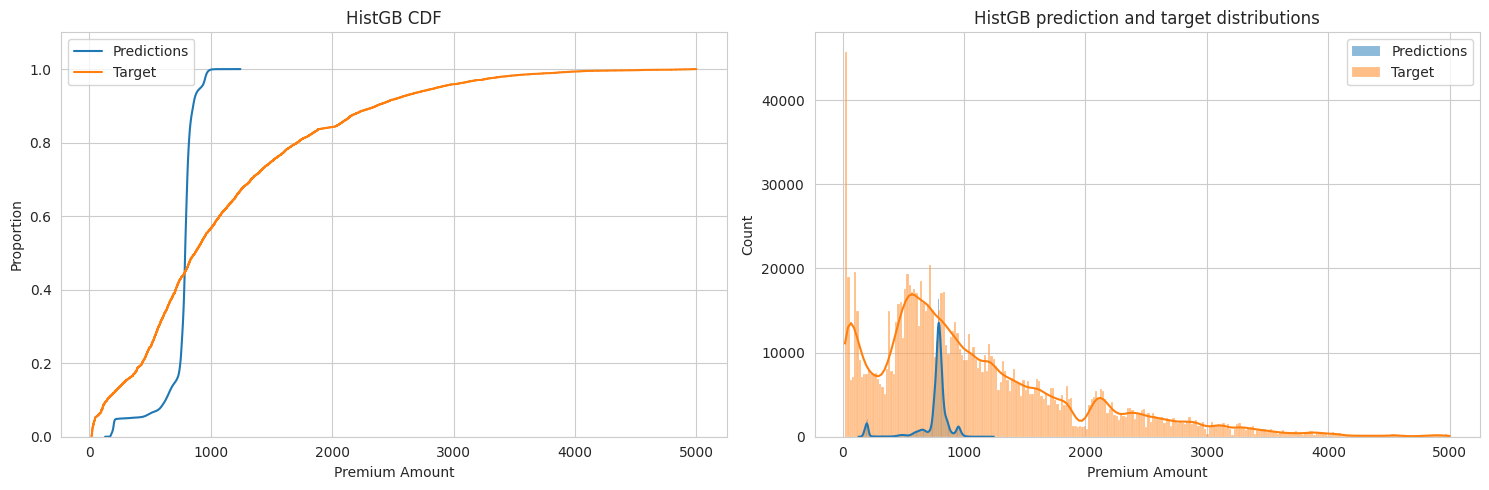

In [11]:
plot_results(oof_preds["HistGB"], y, "HistGB")

## LightGBM (GBDT)

In [12]:
X, y, X_test = get_data("lgbm-gbdt")
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_preds["LightGBM"], test_preds["LightGBM"], scores["LightGBM"], _ = lgbm_trainer.train(X, y, X_test, "lgbm-gbdt")

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04612	valid_0's l2: 1.09437
Early stopping, best iteration is:
[71]	valid_0's rmse: 1.04607	valid_0's l2: 1.09426

--- Fold 1 - RMSLE: 1.046070


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04641	valid_0's l2: 1.09498
[200]	valid_0's rmse: 1.04644	valid_0's l2: 1.09503
Early stopping, best iteration is:
[118]	valid_0's rmse: 1.04638	valid_0's l2: 1.09492

--- Fold 2 - RMSLE: 1.046382


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04781	valid_0's l2: 1.09791
[200]	valid_0's rmse: 1.04781	valid_0's l2: 1.0979
Early stopping, best iteration is:
[149]	valid_0's rmse: 1.04776	valid_0's l2: 1.0978

--- Fold 3 - RMSLE: 1.047761


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04323	valid_0's l2: 1.08833
[200]	valid_0's rmse: 1.04326	valid_0's l2: 1.0884
Early stopp

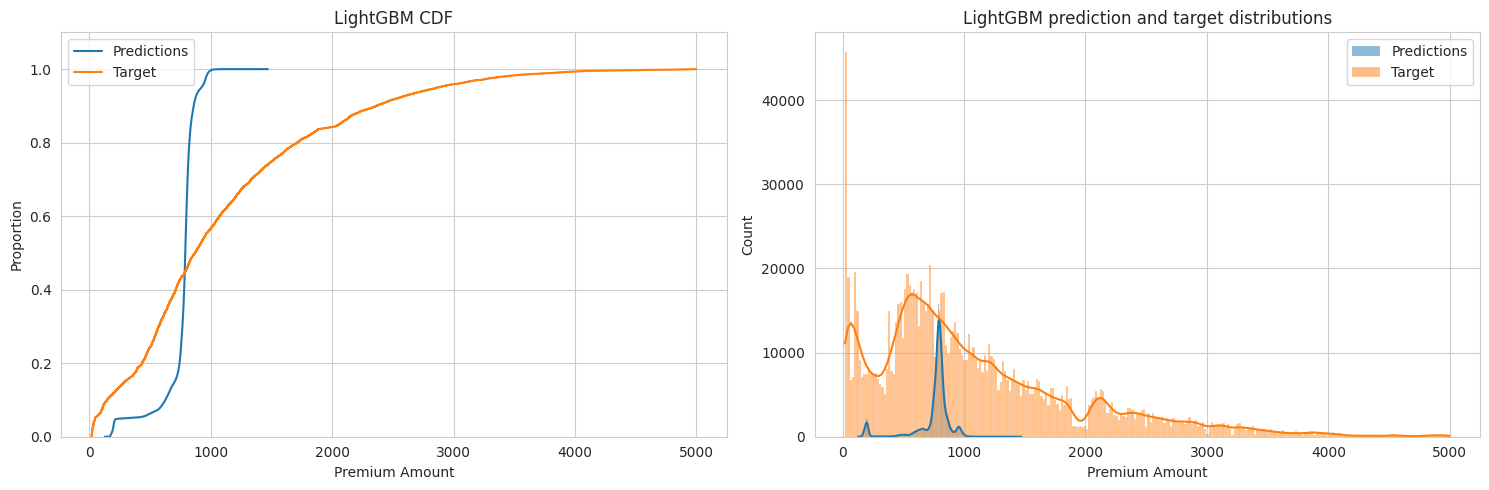

In [13]:
plot_results(oof_preds["LightGBM"], y, "LightGBM")

## LightGBM (GOSS)

In [14]:
X, y, X_test = get_data("lgbm-goss")
lgbm_goss_model = LGBMRegressor(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"], _ = lgbm_goss_trainer.train(X, y, X_test, "lgbm-goss")

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04635	valid_0's l2: 1.09484
[200]	valid_0's rmse: 1.04651	valid_0's l2: 1.09518
Early stopping, best iteration is:
[109]	valid_0's rmse: 1.04633	valid_0's l2: 1.09481

--- Fold 1 - RMSLE: 1.046332


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04687	valid_0's l2: 1.09593
Early stopping, best iteration is:
[61]	valid_0's rmse: 1.04675	valid_0's l2: 1.09568

--- Fold 2 - RMSLE: 1.046746


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0481	valid_0's l2: 1.09851
[200]	valid_0's rmse: 1.04831	valid_0's l2: 1.09896
Early stopping, best iteration is:
[103]	valid_0's rmse: 1.04805	valid_0's l2: 1.09842

--- Fold 3 - RMSLE: 1.048053


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04346	valid_0's l2: 1.0888
[200]	valid_0's rmse: 1.04351	valid_0's l2: 1.08892
Early stop

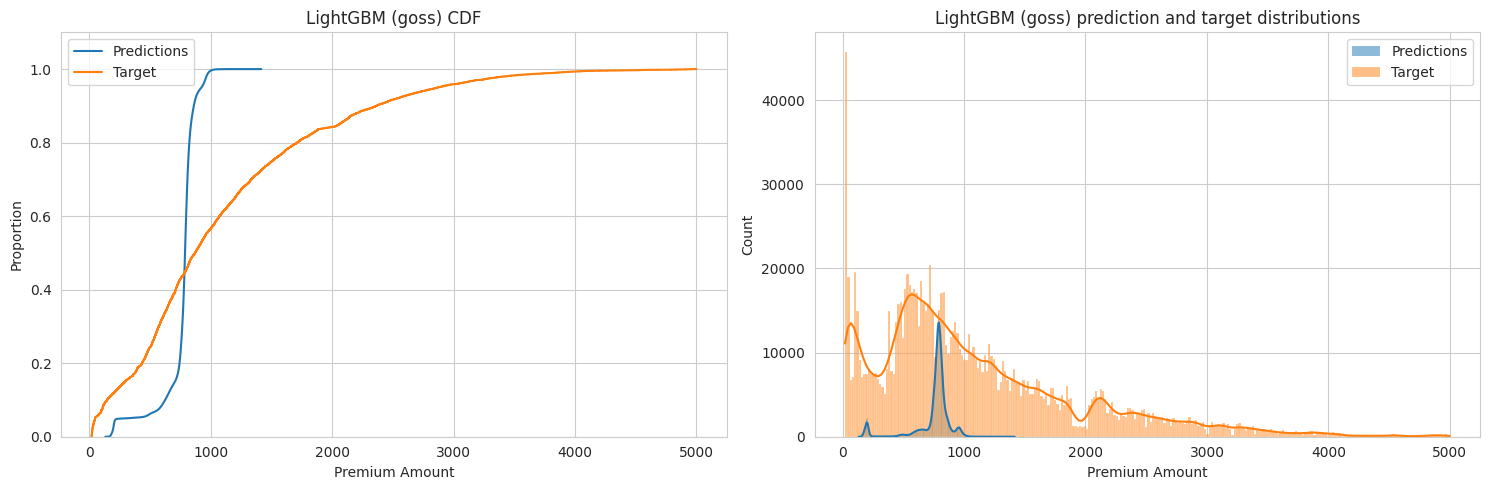

In [15]:
plot_results(oof_preds["LightGBM (goss)"], y, "LightGBM (goss)")

## XGBoost

In [16]:
X, y, X_test = get_data("xgb")
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"], _ = xgb_trainer.train(X, y, X_test, "xgb")

Training XGBRegressor

[0]	validation_0-rmse:1.07304
[100]	validation_0-rmse:1.04702
[152]	validation_0-rmse:1.04780

--- Fold 1 - RMSLE: 1.046480


[0]	validation_0-rmse:1.07338
[100]	validation_0-rmse:1.04783
[125]	validation_0-rmse:1.04824

--- Fold 2 - RMSLE: 1.046974


[0]	validation_0-rmse:1.07431
[100]	validation_0-rmse:1.04842
[143]	validation_0-rmse:1.04897

--- Fold 3 - RMSLE: 1.047959


[0]	validation_0-rmse:1.06957
[100]	validation_0-rmse:1.04461
[118]	validation_0-rmse:1.04492

--- Fold 4 - RMSLE: 1.043650


[0]	validation_0-rmse:1.07397
[100]	validation_0-rmse:1.04950
[120]	validation_0-rmse:1.04974

--- Fold 5 - RMSLE: 1.048699


[0]	validation_0-rmse:1.07077
[100]	validation_0-rmse:1.04577
[126]	validation_0-rmse:1.04605

--- Fold 6 - RMSLE: 1.044998


[0]	validation_0-rmse:1.07080
[100]	validation_0-rmse:1.04499
[143]	validation_0-rmse:1.04572

--- Fold 7 - RMSLE: 1.044102


[0]	validation_0-rmse:1.07294
[100]	validation_0-rmse:1.04601
[132]	validation_0-rmse:1.04658



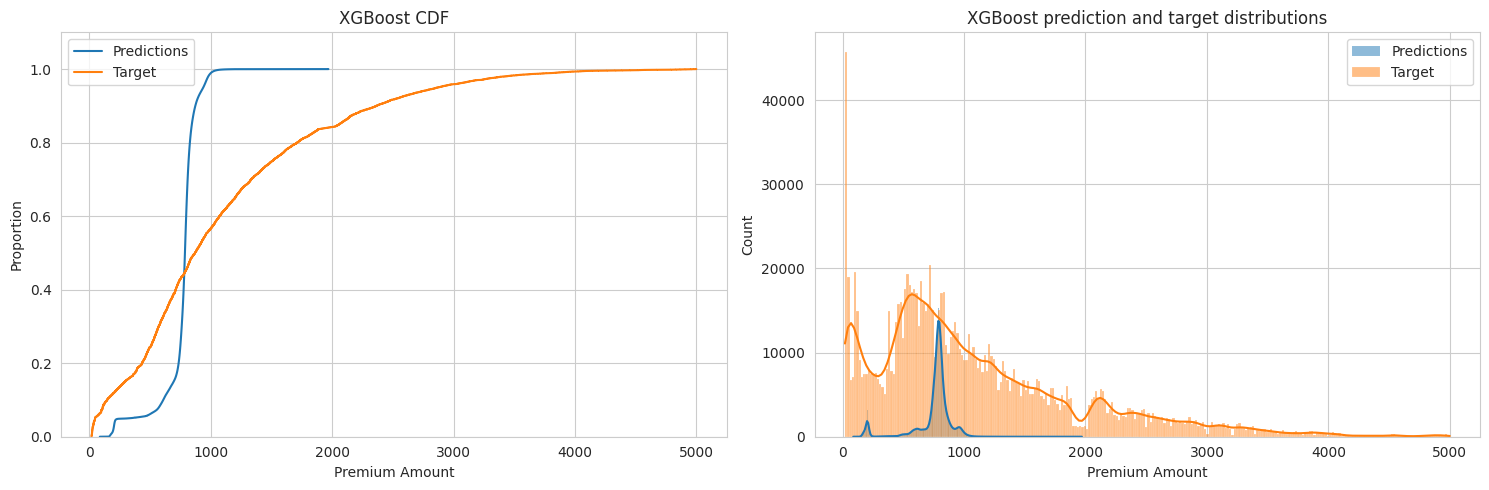

In [17]:
plot_results(oof_preds["XGBoost"], y, "XGBoost")

## CatBoost

In [18]:
X, y, X_test = get_data("cb")
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model)
oof_preds["CatBoost"], test_preds["CatBoost"], scores["CatBoost"], _ = cb_trainer.train(X, y, X_test, "cb")

Training CatBoostRegressor

Learning rate set to 0.152456
0:	learn: 1.0871726	test: 1.0876262	best: 1.0876262 (0)	total: 1.12s	remaining: 18m 41s
100:	learn: 1.0478523	test: 1.0489300	best: 1.0489300 (100)	total: 1m 17s	remaining: 11m 26s
200:	learn: 1.0461968	test: 1.0477824	best: 1.0477824 (199)	total: 2m 35s	remaining: 10m 16s
300:	learn: 1.0452903	test: 1.0474763	best: 1.0474763 (300)	total: 3m 51s	remaining: 8m 57s
400:	learn: 1.0443857	test: 1.0472611	best: 1.0472611 (400)	total: 5m 12s	remaining: 7m 46s
500:	learn: 1.0436066	test: 1.0471276	best: 1.0471276 (500)	total: 6m 33s	remaining: 6m 32s
600:	learn: 1.0428792	test: 1.0471192	best: 1.0471072 (583)	total: 7m 54s	remaining: 5m 15s
700:	learn: 1.0421686	test: 1.0470660	best: 1.0470598 (690)	total: 9m 16s	remaining: 3m 57s
800:	learn: 1.0415291	test: 1.0470392	best: 1.0470323 (796)	total: 10m 38s	remaining: 2m 38s
900:	learn: 1.0408498	test: 1.0470282	best: 1.0470127 (813)	total: 12m	remaining: 1m 19s
Stopped by overfitting det

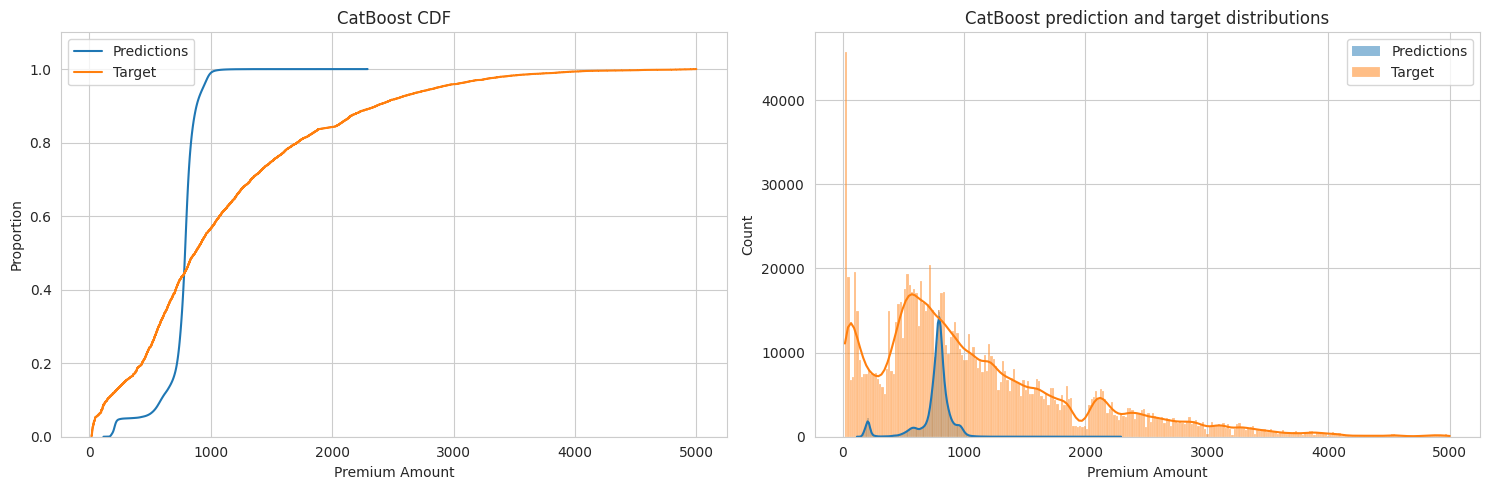

In [19]:
plot_results(oof_preds["CatBoost"], y, "CatBoost")

## AutoGluon

In [20]:
# oof_preds_files = glob.glob(f'/kaggle/input/s04e12-insurance-premium-prediction-autogluon/*_oof_preds_*.pkl')
# test_preds_files = glob.glob(f'/kaggle/input/s04e12-insurance-premium-prediction-autogluon/*_test_preds_*.pkl')

# ag_oof_preds = np.log1p(pickle.load(open(oof_preds_files[0], 'rb')))
# ag_test_preds = np.log1p(pickle.load(open(test_preds_files[0], 'rb')))

# ag_scores = []
# split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
# for _, val_idx in split:
#     y_val = y[val_idx]
#     y_preds = ag_oof_preds[val_idx]   
#     score = root_mean_squared_error(y_preds, y_val)
#     ag_scores.append(score)
    
# oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

In [21]:
# plot_results(oof_preds["AutoGluon"], y, "AutoGluon")

# Ensembling with Ridge

In [22]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [23]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [24]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 100),
        'tol': trial.suggest_float('tol', 1e-10, 1e-2)
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=250, n_jobs=-1)
best_params = study.best_params

[I 2024-12-05 15:29:06,893] A new study created in memory with name: no-name-c8758aee-da9a-480c-818d-639db6b5be61
[I 2024-12-05 15:29:18,348] Trial 0 finished with value: 1.045357730240596 and parameters: {'alpha': 69.8753189810607, 'tol': 0.0017758010733900978}. Best is trial 0 with value: 1.045357730240596.
[I 2024-12-05 15:29:18,503] Trial 2 finished with value: 1.0453577211925311 and parameters: {'alpha': 16.226626504023443, 'tol': 0.0052071036795100605}. Best is trial 2 with value: 1.0453577211925311.
[I 2024-12-05 15:29:18,618] Trial 1 finished with value: 1.0453577440122461 and parameters: {'alpha': 73.59002120227032, 'tol': 0.009097507892329932}. Best is trial 2 with value: 1.0453577211925311.
[I 2024-12-05 15:29:18,950] Trial 3 finished with value: 1.0453578612417311 and parameters: {'alpha': 97.08626465684316, 'tol': 0.006795143936867447}. Best is trial 2 with value: 1.0453577211925311.
[I 2024-12-05 15:29:29,918] Trial 5 finished with value: 1.0453578014770528 and parameters

In [25]:
ridge_params = {
    'random_state': CFG.seed,
    'alpha': best_params['alpha'],
    'tol': best_params['tol']
}
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 40.6524814174758,
  "tol": 0.007601150166048268
}


In [26]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
ridge_oof_preds, ridge_test_preds, scores["Ensemble (Ridge)"], ridge_coeffs = ridge_trainer.train(X, y, X_test, "ensemble-ridge")

Training Ridge

--- Fold 1 - RMSLE: 1.045666
--- Fold 2 - RMSLE: 1.046244
--- Fold 3 - RMSLE: 1.047472
--- Fold 4 - RMSLE: 1.042958
--- Fold 5 - RMSLE: 1.047915
--- Fold 6 - RMSLE: 1.044332
--- Fold 7 - RMSLE: 1.043348
--- Fold 8 - RMSLE: 1.044464
--- Fold 9 - RMSLE: 1.041724
--- Fold 10 - RMSLE: 1.049453

------ Overall RMSLE: 1.045360 - Average RMSLE: 1.045358


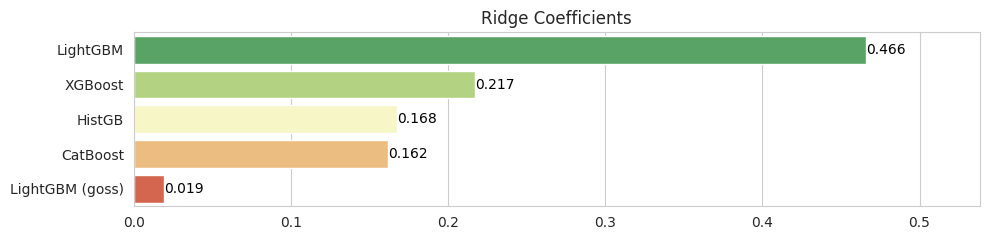

In [27]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

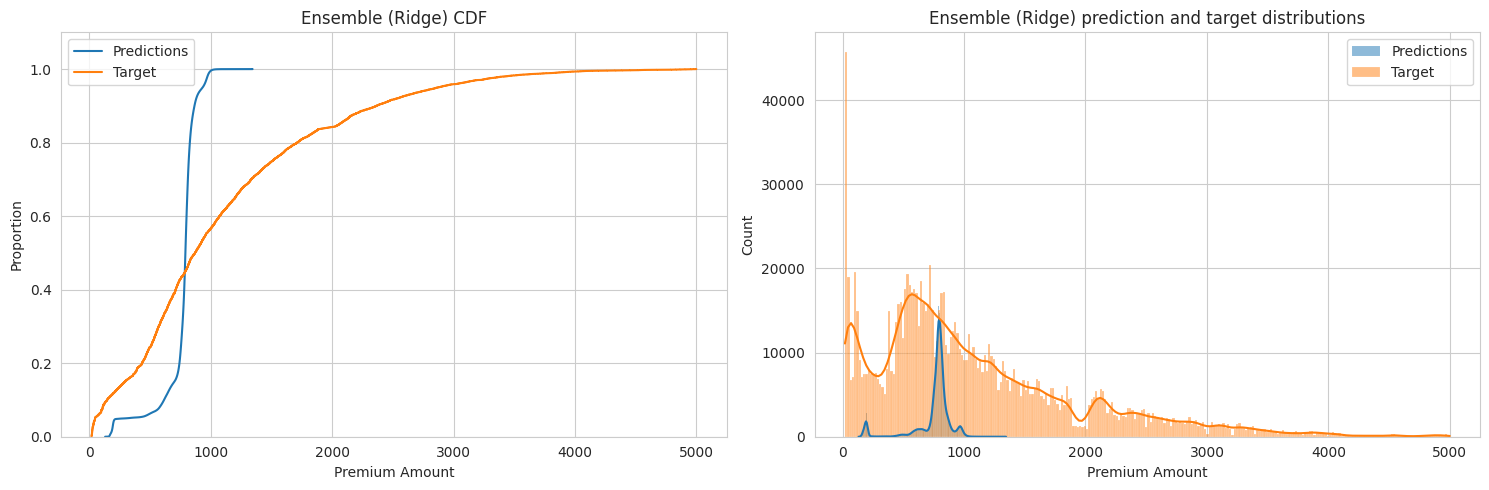

In [28]:
plot_results(ridge_oof_preds, y, "Ensemble (Ridge)")

In [29]:
save_sub("ensemble-ridge", ridge_test_preds, np.mean(scores["Ensemble (Ridge)"]))

,id,Premium Amount
0,1200000,855.780208
1,1200001,797.195553
2,1200002,788.718301
3,1200003,804.905156
4,1200004,755.752938
...,...,...
799995,1999995,975.909688
799996,1999996,571.816784
799997,1999997,818.922432
799998,1999998,811.154595


# Results

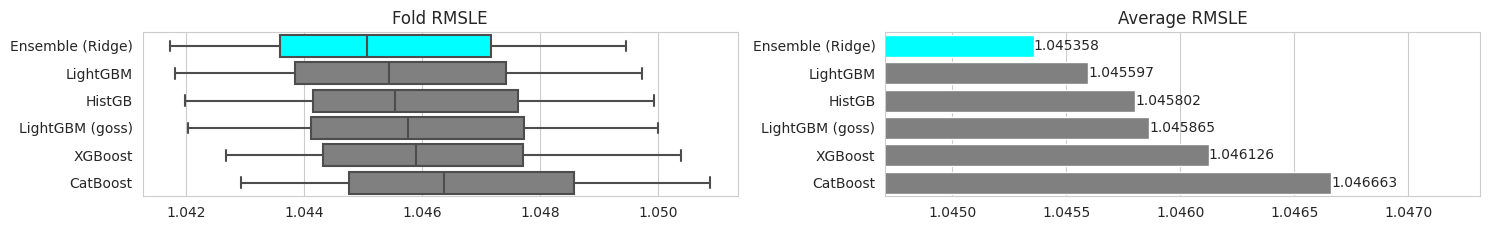

In [30]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

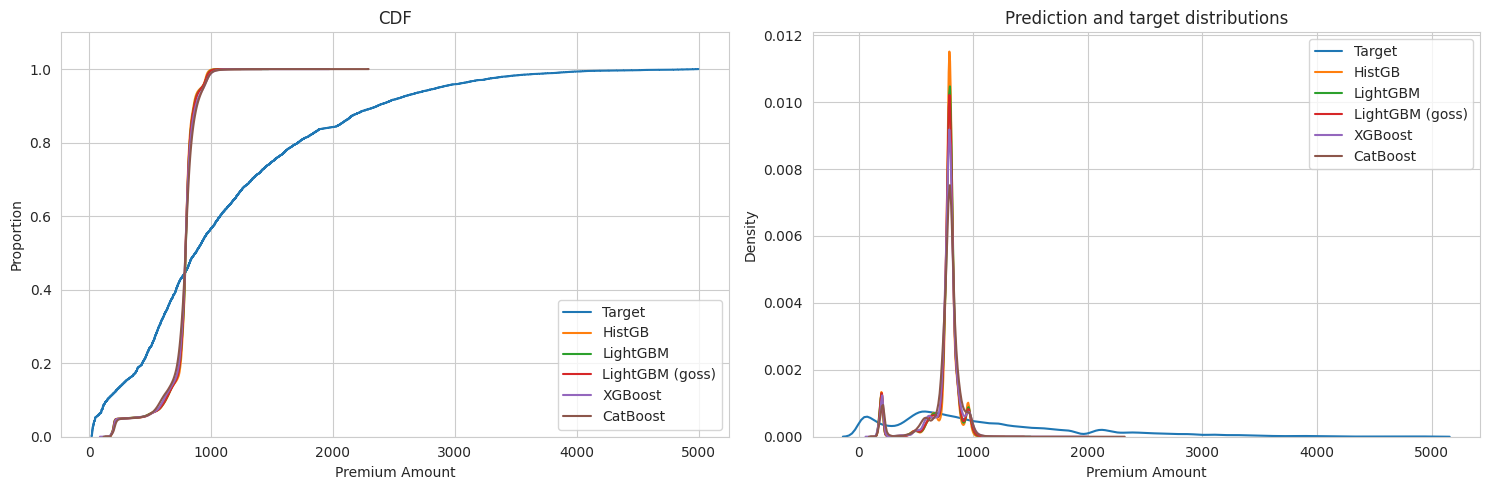

In [31]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.ecdfplot(np.expm1(y), label="Target", ax=axes[0])
for model in oof_preds:
    sns.ecdfplot(np.expm1(oof_preds[model]), label=model, ax=axes[0])
axes[0].set_title("CDF")
axes[0].legend(loc="best")
axes[0].set_ylim(0, 1.1)

sns.kdeplot(np.expm1(y), ax=axes[1], label='Target')
for model in oof_preds:
    sns.kdeplot(np.expm1(oof_preds[model]), ax=axes[1], label=model)
axes[1].set_title("Prediction and target distributions")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

In [32]:
shutil.rmtree("catboost_info", ignore_errors=True)